In [1]:
# importing needed libs

import numpy as np
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### Подготовка данных

In [2]:
# connecting to the database and obtaining ctr date for the users in 1 and 2 experimental groups
# for the period of time between 22 and 28 November inclusive

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20241220'
}

query = """
SELECT
  user_id,
  exp_group,
  views,
  likes,
  ROUND(likes / views, 2) AS ctr
FROM
  (
    SELECT
      user_id,
      exp_group,
      sum(action = 'view') AS views,
      sum(action = 'like') AS likes
    FROM
      simulator_20241220.feed_actions
    WHERE
      toDate(time) >= '2024-11-22'
      AND toDate(time) <= '2024-11-28'
      AND exp_group in (2, 1)
    GROUP BY
      user_id,
      exp_group
  )
"""

df = pandahouse.read_clickhouse(query, connection=connection)

df.head()

,user_id,exp_group,views,likes,ctr
0,109963,1,15,3,0.20
1,26117,1,141,32,0.23
2,138232,1,73,18,0.25
3,26295,1,141,39,0.28
4,18392,1,32,7,0.22


In [3]:
# checking that groups are about the same size

df.groupby('exp_group').count()

,user_id,views,likes,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


Как видно, количество наблюдений в контрольной и тестовой группах примерно одинаковое. Посмотрим на распределения CTR визуально.

In [4]:
# devide and save data into two groups

control_group_ctr = df[df.exp_group == 1].ctr
test_group_ctr = df[df.exp_group == 2].ctr

Text(0.5, 0, 'CTR')

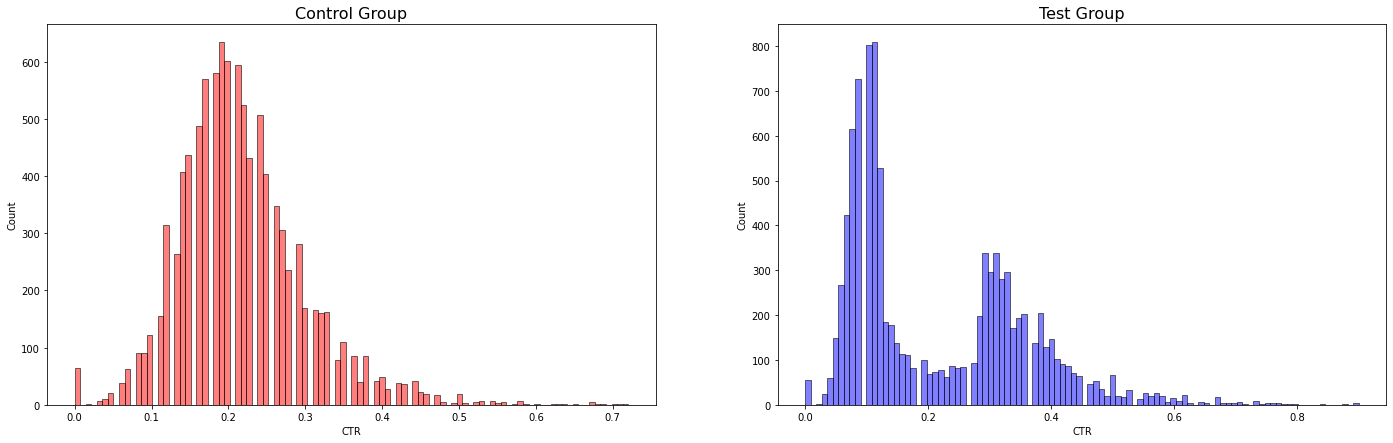

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(24, 7))

sns.histplot(ax=axs[0],
             x=control_group_ctr,
             color='r',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[0].set_title('Control Group', fontsize=16)
axs[0].set_xlabel('CTR')

sns.histplot(ax=axs[1],
             x=test_group_ctr,
             color='b',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[1].set_title('Test Group', fontsize=16)
axs[1].set_xlabel('CTR')

На гистограммах данных видно, что распределение для контрольной группы близкое к нормальному, в то время как для тестовой группы нет, но так как количество наблюдений в обеих группах большое (около 10 тыс.), то можно провести Т-тест, однако с осторожностью подходя к интерпретации результатов. Так же, по скольку на графиках невозможно оценить абсолютные значения средних, их следует узнать.

In [6]:
f"Average in control group is {control_group_ctr.mean().round(4)} and in test group is {test_group_ctr.mean().round(4)}"

'Average in control group is 0.2167 and in test group is 0.2161'

Как можно видеть выше, абсолютные значения средних отличаются лишь на 4-й знак после запятой, причем у тестовой группы меньше. 

### Т-тест и U-тест Манна-Уитни

In [7]:
# counting t-test statistics

stats.ttest_ind(control_group_ctr,
                test_group_ctr,
                equal_var=False
               )[1]

0.6921668985029372

Как видно Т-тест показал значение p-value больше 0.05, что не могло бы дать достаточно оснований для отклонений нулевой гипотезы, если бы распределения для обеих групп были нормальными. Чтобы расширить базу фактов для принятия решения о пользе нового алгоритма проведем так же U-тест. Как известно, U-тест проверяет гипотезу о равности медиан, поэтому было бы не плохо узнать их абсолютные значения для обеих групп.

In [8]:
control_group_ctr

0        0.20
1        0.23
2        0.25
3        0.28
4        0.22
         ... 
19886    0.18
19887    0.38
19890    0.19
19892    0.16
19893    0.19
Name: ctr, Length: 10020, dtype: float64

In [9]:
f"Median in control group is {control_group_ctr.median()} and in test group is {test_group_ctr.median()}"

'Median in control group is 0.21 and in test group is 0.15'

Медианный CTR в контрольной группе выше, чем в тестовой, что может говорить об ухудшении CTR нового алгоритма, и в данном случае намного значительнее.

In [10]:
# counting U-test statistics

stats.mannwhitneyu(control_group_ctr,
                test_group_ctr
               )[1]

6.509971658856411e-45

Как видно U-test показал p-value значительно меньше 0.05, что говорит о значимом различии в медианах групп и распределений в целом.

Было бы полезно посмотреть на данные после некоторого преобразования - в частности сглаживания Лапласа, чтобы несколько стабилизировать их. Врядли это приведет к нормализации распределения тестовой группы, но попробовать стоит.

### Сглаживание данных

In [11]:
# smoothing data function

def data_smoother(likes, views, global_ctr, alpha=5):
    smoothed_ctr = (likes + alpha * global_ctr) / (views + alpha)
    return smoothed_ctr

In [12]:
# deviding all data into two groups test and control and calculating global ctr for each group

df_control = df.query('exp_group == 1')
control_global_ctr = df.query('exp_group == 1').likes.sum() / df.query('exp_group == 1').views.sum()

df_test = df.query('exp_group == 2')
test_global_ctr = df.query('exp_group == 2').likes.sum() / df.query('exp_group == 2').views.sum()

In [13]:
# creating a new column applying smothing function

df_control['smoothed_ctr'] = data_smoother(df_control.likes,
                                   df_control.views,
                                   control_global_ctr,
                                   alpha=5
                                  )

df_test['smoothed_ctr'] = data_smoother(df_test.likes,
                                   df_test.views,
                                   test_global_ctr,
                                   alpha=5
                                  )

/tmp/ipykernel_93/2397296315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control['smoothed_ctr'] = data_smoother(df_control.likes,
/tmp/ipykernel_93/2397296315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['smoothed_ctr'] = data_smoother(df_test.likes,


Text(0.5, 0, 'CTR')

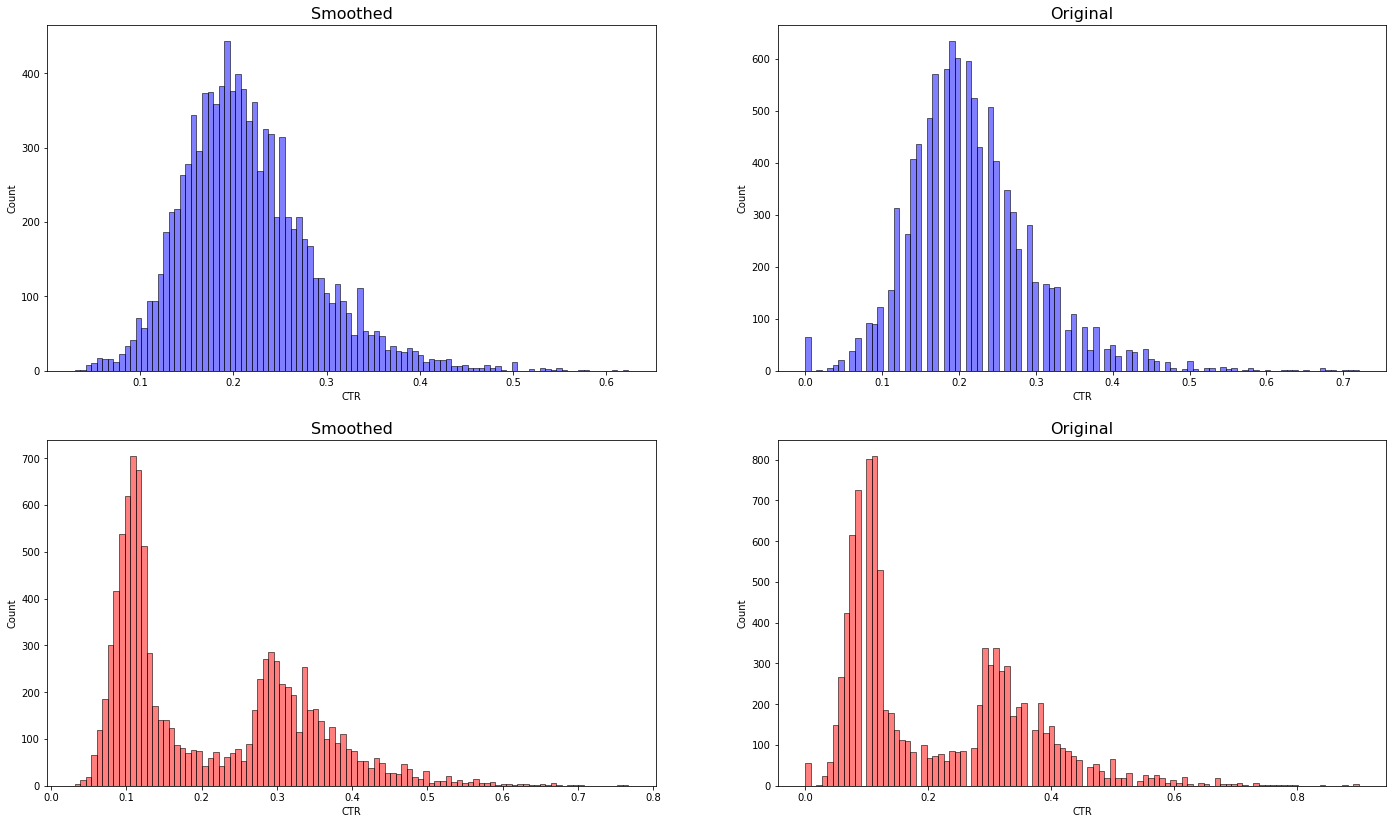

In [14]:
# creating two plots to compare Smoothed CTR with the original CTR for the TEST group

fig, axs = plt.subplots(2, 2, figsize=(24, 14))

sns.histplot(ax=axs[0, 0],
             x=df_control['smoothed_ctr'],
             color='b',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[0, 0].set_title('Smoothed', fontsize=16)
axs[0, 0].set_xlabel('CTR')

sns.histplot(ax=axs[0, 1],
             x=df_control.ctr,
             color='b',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[0, 1].set_title('Original', fontsize=16)
axs[0, 1].set_xlabel('CTR')

sns.histplot(ax=axs[1, 0],
             x=df_test['smoothed_ctr'],
             color='r',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[1, 0].set_title('Smoothed', fontsize=16)
axs[1, 0].set_xlabel('CTR')

sns.histplot(ax=axs[1, 1],
             x=df_test.ctr,
             color='r',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[1, 1].set_title('Original', fontsize=16)
axs[1, 1].set_xlabel('CTR')

После сглаживания данных графики приняли более плавный вид, особенно это позволило избавиться от данных с CTR равным 0, однако это так и не решило основную проблему - ненормальность распределения CTR в тестовой группе. Тем не менее попробуем применить Т-тест и U-тест на сглаженных данных.

In [15]:
stats.ttest_ind(df_control['smoothed_ctr'], df_test['smoothed_ctr'], equal_var=False)[1]

0.05166679015318526

In [16]:
stats.mannwhitneyu(df_control['smoothed_ctr'], df_test['smoothed_ctr'])[1]

2.396534039374286e-50

Как можно увидеть U-тест все так же дает значимые различия, но несмотря на то, что Т-тест все еще показал p-value выше 0.05, на этот раз уже приблизительно равно пороговому значению. Так или иначе, особой роли сглаживание не сыграло, поэтому для дальнейшего анализа прибегнем к Пуассновскому Бутстрапу.

### Bootstrap

In [17]:
# poisson bootstrap function that receives likes and views of both groups,
# counts weight for every user by their number of likes and their encounter frequency,
# then concidering these weights counts global ctr for both groups

def bootstrap(likes_control,
              views_control,
              likes_test,
              views_test
             ):
    
    weight_control = stats.poisson(1).rvs((2000, len(likes_control))).astype(np.int64)
    weight_test = stats.poisson(1).rvs((2000, len(likes_test))).astype(np.int64)
    
    bootstraped_ctr_control = (weight_control * likes_control).sum(axis=1) / (weight_control * views_control).sum(axis=1)
    bootstraped_ctr_test = (weight_test * likes_test).sum(axis=1) / (weight_test * views_test).sum(axis=1)
    
    return bootstraped_ctr_control, bootstraped_ctr_test

In [18]:
# deviding data into likes and views for both groups

likes_control = df_control.likes.to_numpy()
views_control = df_control.views.to_numpy()
likes_test = df_test.likes.to_numpy()
views_test = df_test.views.to_numpy()

In [19]:
# counting global weight CTRs for both groups

bootstraped_ctr_control, bootstraped_ctr_test = bootstrap(likes_control,
                                                          views_control,
                                                          likes_test,
                                                          views_test
                                                         )

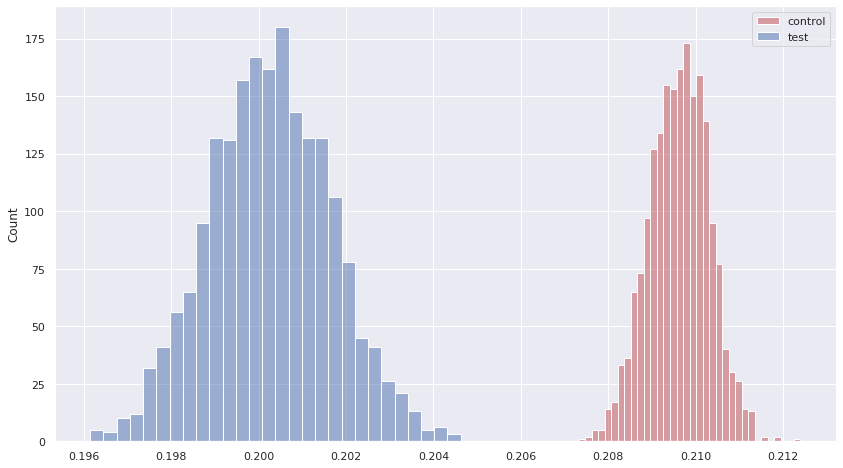

In [20]:
# making a graph

sns.set(rc={'figure.figsize':(14, 8)})

sns.histplot(x=bootstraped_ctr_control,
             kde=False,
             label='control',
             color='r',
             alpha=0.5
            )
sns.histplot(x=bootstraped_ctr_test,
             kde=False,
             label='test',
             color='b',
             alpha=0.5
            )
plt.legend()

### 

Даже без проведения T-теста по гистограммам бутстропированных данных приведенным выше видно, что CTR в тестовой группе значимо отличается от CTR в контрольной группе. Так же видно, что CTR пользователей в тестовой группе все так же меньше, чем в контрольной.

In [21]:
# just to make sure

stats.ttest_ind(bootstraped_ctr_control, bootstraped_ctr_test, equal_var=False)[1]

0.0

Как видно, p-value < 0.05

На данный момент для принятия решения о внедрении нового алгоритма данных достаточно.

### Пояснения

**Почему тесты так сработали?**

Главная причина, почему тесты сработали именно так, на мой взгляд в том, что распределение CTR у тестовой группы отличается от распределения CTR у контрольной группы и далеко от нормального.

**Почему произошло такое изменение?**

Первое что бросается в глаза на гистрограмме CTR тестовой группы - это бимодальность, чего нет на гистограмме CTR контрольной. Сказать однозначно причину такого изменения нельзя, без более глубокого анализа.

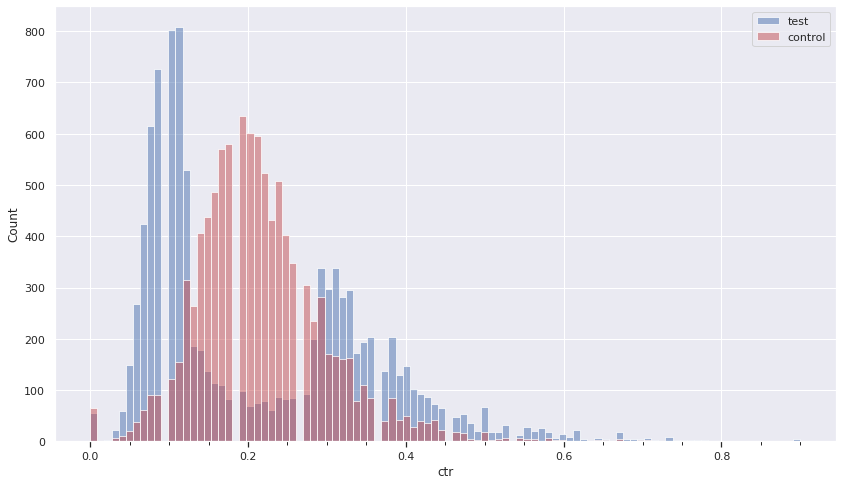

In [22]:
# first of all assessing the data visually
sns.set(rc={'xtick.bottom': True, 'figure.figsize':(14, 8)})

groups = sns.histplot(data=df,
                    x='ctr',
                    hue='exp_group',
                    palette=['r', 'b'],
                    alpha=0.5,
                    kde=False,
                    bins=100
)

groups.legend(labels=['test', 'control'])
groups.minorticks_on()

Так как на гистограмме тестовой группы наблюдается два пика по обе стороны относительно пика гистограммы контрольной группы, то можно предположить, что части пользователей алгоритм понравился, а части нет. Соответственно увеличилась как доля тех, кто начал ставить больше лайков, так и доля тех кто начал ставить меньше лайков. Однако следует убедиться что новый алгоритм в целом не повлиял на активность аудитории. Для этого как минимум проверим общее количество просмотров.

In [23]:
f"Sum of views in control group is {df.query('exp_group == 1').views.sum()} \
and in test group is {df.query('exp_group == 2').views.sum().sum()}"

'Sum of views in control group is 669543 and in test group is 659454'

Так как абсолютное количество просмотров в обеих группах соразмерно, то изменение CTR скорее всего обусловлено изменением количества лайков, а не падением активности аудитории. Еще интересно было бы узнать доли пользователей у которых CTR вырос, и долю тех у кого упал.

In [24]:
df_control_median = df.query('exp_group == 1').ctr.median()

lower_med = round(df.query('exp_group == 2 and ctr < @df_control_median').count()[0] * 100 / df.query('exp_group == 2').count()[0], 2)
higher_med = round(df.query('exp_group == 2 and ctr >= @df_control_median').count()[0] * 100 / df.query('exp_group == 2').count()[0], 2)

f"In the CTR distribution of the test group {higher_med}% of users now have CTR higher and\
 {lower_med}% lower compared to the median value of the CTR data of the control group"

'In the CTR distribution of the test group 44.95% of users now have CTR higher and 55.05% lower compared to the median value of the CTR data of the control group'

Как видно выше CTR большей части пользователей в тестовой группе снизился относительно медианного значения CTR контрольной группы. Это к сожалению в очередной раз подтверждает, что скорее всего количество тех кому алгоритм не понравился больше чем тех кому да.

**Рекомендация по поводу внедрения нового алгоритма**

В результате сравнения данных для контрольной и тестовой групп было установлено, что:
- данные имеют значимые различия выраженные в характере распределения CTR
- данные имеют значимые различия выраженные в значении p-value полученного применением t-теста на бутстрапированных данных и u-теста на исходных данных
- абсолютные значения медиан и средних на оригинальных данных меньше в тестовой группе, чем в контрольной
- на бутстрапированных данных CTR пользователей в тестовой группе меньше, чем в контрольной
- в тестовой группе количество пользователей с CTR ниже медианого значения CTR тестовой группы возросло

В качестве итога можно сказать что новый алгоритм рекомендаций отличается от текущего в худшую сторону.

Рекомендации:
1. Внедрение нового алгоритма для всех пользователей нецелесообразно, по скольку он показал значимый результат в худшую сторону.
2. Так как есть часть пользователей у которых CTR вырос, есть смысл в доработке алгоритма.
